# FNN


## Lendo dados e preparando tensores


In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("dados.csv", index_col=0)

ciclos = df.index.values
t_feed = df["t_feed"].values
t_rinse = df["t_rinse"].values
t_blow = df["t_blow"].values
t_purge = df["t_purge"].values

purity_H2 = df["purity_H2"].values
H2_CO_ratio = df["H2_CO_ratio"].values
purity_CO2 = df["purity_CO2"].values
recovery_CO2 = df["recovery_CO2"].values
productivity = df["productivity"].values


In [2]:
y = np.array(
    [
        purity_H2,
        H2_CO_ratio,
        purity_CO2,
        recovery_CO2,
        productivity,
    ]
).T
u = np.array([t_feed, t_rinse, t_blow, t_purge]).T


In [3]:
import torch

from lib.models import DataInfo

# Concatena entradas (y_k, u_k)
X = np.hstack([y[:-1], u[:-1]])  # (N-1, 9)
Y = y[1:]  # (N-1, 5)

# Converte para tensores
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

dataInfo: DataInfo = {
    "in_min": torch.min(X, dim=0).values,
    "in_max": torch.max(X, dim=0).values,
    "out_min": torch.min(Y, dim=0).values,
    "out_max": torch.max(Y, dim=0).values,
}


## Criando e Treinando a Rede Neural


In [4]:
from lib.models import FNN

input_size = 9
hidden_size = 64
output_size = 5

model = FNN(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    dataInfo=dataInfo,
)


In [5]:
def loss_fn(model, params):
    Y_pred = model(X)  # predição do modelo
    loss = torch.mean((Y_pred - Y) ** 2)

    # status pode registrar info por época (exemplo: loss atual)
    status = loss.detach().cpu().numpy()
    return loss, status


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = model.fit(
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=3000,
    loss_fn_params=None,
)


Epoch 0 loss: 3.7478630542755127
Epoch 100 loss: 1.090683937072754
Epoch 200 loss: 0.9325239062309265
Epoch 300 loss: 0.7789444327354431
Epoch 400 loss: 0.6235449910163879
Epoch 500 loss: 0.4714375436306
Epoch 600 loss: 0.3631848394870758
Epoch 700 loss: 0.33881041407585144
Epoch 800 loss: 0.3141489326953888
Epoch 900 loss: 0.2838834822177887
Epoch 1000 loss: 0.232740119099617
Epoch 1100 loss: 0.2517165243625641
Epoch 1200 loss: 0.22326955199241638
Epoch 1300 loss: 0.2219725400209427
Epoch 1400 loss: 0.340873122215271
Epoch 1500 loss: 0.4038139283657074
Epoch 1600 loss: 0.374447762966156
Epoch 1700 loss: 0.30065152049064636
Epoch 1800 loss: 0.2496282160282135
Epoch 1900 loss: 0.5005886554718018
Epoch 2000 loss: 0.4430813789367676
Epoch 2100 loss: 0.4087778329849243
Epoch 2200 loss: 0.38587236404418945
Epoch 2300 loss: 0.361881822347641
Early stopping ativado. Treinamento interrompido.
Loss Final: 0.33754509687423706


## Simulando


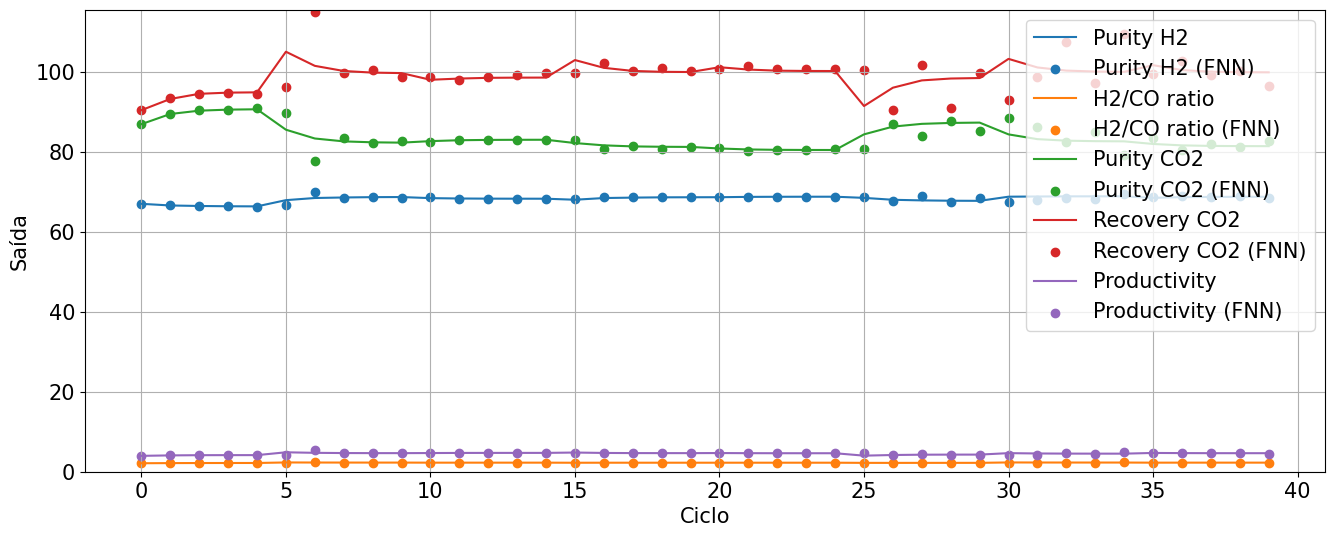

In [6]:
from lib.plot import plot_comparison

y_nn = np.zeros_like(y)
y_nn[0] = y[0]  # inicializa com o primeiro valor

model.eval()

for k in range(1, len(y)):
    phi_k = np.concatenate([y_nn[k - 1], u[k - 1]])
    phi_k = torch.tensor(phi_k, dtype=torch.float32)
    y_nn[k] = model(phi_k).detach().numpy()

plot_comparison(ciclos, y, y_nn, "FNN")
